In [1]:
import numpy as np
import leaderbot as lb
import pickle
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter
import texplot
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import cmasher as cmr

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']
test_data = results['test_data']
test_data_no_tie = results['test_data_no_tie']
proc_time = np.array(results['proc_time'])
wall_time = np.array(results['wall_time'])

In [3]:
def plot_match_matrices_helper(fig, ax, matrix, data_range, density=True,
                               title='', cbar_label='', extend=None,
                               xlabel=False, ylabel=False, cmap=None):
    """
    Helper function for :func:`leaderbot.models.BaseModel.match_matrix`.
    """

    if data_range is None:
        data_vmin = np.ma.min(matrix)
        data_vmax = np.ma.max(matrix)
    else:
        data_vmin, data_vmax = data_range

    # snap = 0.03
    # vmin = round(vmin / snap) * snap
    # vmax = round(vmax / snap) * snap

    step_size = 5
    labels = [1] + \
        [i for i in range(step_size, matrix.shape[0] + 1, step_size)]

    if cmap is None:
        cmap = 'gist_heat_r'

    # Heatmap for wins
    if density:
        im = ax.imshow(100.0 * matrix, cmap=cmap, vmin=100.0*data_vmin,
                       vmax=100.0*data_vmax)
    else:
        im = ax.imshow(matrix, cmap=cmap, vmin=data_vmin,
                       vmax=data_vmax)

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    if xlabel:
        ax.set_xticks([0] + list(np.arange(step_size-1, matrix.shape[0], step_size)))
        ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
        ax.set_xlabel(r'Rank ($j$)')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    if ylabel:
        ax.set_yticks([0] + list(np.arange(step_size-1, matrix.shape[0], step_size)))
        ax.set_yticklabels(labels, fontsize=10)
        ax.set_ylabel(r'Rank ($i$)')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    ax.tick_params(axis='both', length=0)    
    # ax.text(0.5, -0.02, title, ha='center', va='top', transform=ax.transAxes)

    # divider1 = make_axes_locatable(ax)
    # cax1 = divider1.append_axes("right", size="5%", pad=0.06)

    # # Diagonals (which are masked) have value of zero. If vmin is larger than
    # # zero, ensure to use a colomap that reaches white color and make colorbar
    # # to show the extend mark.
    # if extend is None:
    #     if data_vmin > 0.0:
    #         extend = 'min'
    #     else:
    #         extend = 'neither'

    # cbar1 = fig.colorbar(im, cax=cax1, extend=extend)
    # cbar1.set_label(cbar_label)

    # if density:
    #     cbar1.ax.yaxis.set_major_formatter(
    #         mticker.PercentFormatter(decimals=0))
    return im

In [4]:
def remove_rows_cols_masked(matrix, indices):
    # Delete rows
    smaller_data = np.delete(matrix.data, indices, axis=0)
    smaller_mask = np.delete(matrix.mask, indices, axis=0)

    # Delete columns
    smaller_data = np.delete(smaller_data, indices, axis=1)
    smaller_mask = np.delete(smaller_mask, indices, axis=1)

    # Return the new masked array
    return np.ma.masked_array(smaller_data, mask=smaller_mask)

def plot_match_matrix(ax, model, rank, density=True, source='observed', kind='win',
                      data_range=None, rm_indices=None, title='', cmap=None,
                      xlabel=False, ylabel=False, save=False, latex =False):
   
    x = model.x
    y = model.y

    max_rank = rank.size

    y_sum = y.sum(axis=1, keepdims=True)
    y_sum = np.tile(y_sum, (1, y.shape[1]))
    p_obs = y / y_sum

    # Find which rows of X has (i, j) indices both from rank_
    mask = np.isin(x[:, 0], rank) & np.isin(x[:, 1], rank)
    row_indices = np.where(mask)[0]

    # The map j = rank_[i] indicates the rank of i of j. Conversely, the
    # inverse map i = inverse_rank_[j] indicates the one element with ran
    # j is the i-th data
    inverse_rank = {value: idx for idx, value in enumerate(rank)}

    # Check arguments
    if source not in ['observed', 'predicted']:
        raise ValueError('Invalid "source" argument.')

    # Generate match matrices for observed data
    if source == 'observed':

        # Initialize matrices
        if density:
            # probability of observations
            p_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=float)
            p_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=float)
        else:
            # Count (frequency) of observations
            n_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=int)
            n_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=int)

        # Iterate over all rows of input data x containing rank_ indices
        for row in row_indices:

            # Get the actual indices
            i, j = x[row, :]

            # Get the rank of these indices
            rank_i = inverse_rank.get(i, None)
            rank_j = inverse_rank.get(j, None)

            if density:
                # Probability of observations
                p_obs_win[rank_i, rank_j] = p_obs[row, 0]
                p_obs_win[rank_j, rank_i] = p_obs[row, 1]  # use loss
                p_obs_tie[rank_i, rank_j] = p_obs[row, 2]
                p_obs_tie[rank_j, rank_i] = p_obs[row, 2]  # symmetry
            else:
                # Count (frequency) of observations
                n_obs_win[rank_i, rank_j] = y[row, 0]
                n_obs_win[rank_j, rank_i] = y[row, 1]  # use loss
                n_obs_tie[rank_i, rank_j] = y[row, 2]
                n_obs_tie[rank_j, rank_i] = y[row, 2]  # symmetry

    # Generate match matrices for predicted data
    if source == 'predicted':

        if density:
            # Construct the list of all pairs between elements in the rank_
            # array, even though they might not have had real match. We
            # will make prediction for these pairs.
            x_all = []

            for i in range(max_rank-1):
                for j in range(i+1, max_rank):
                    x_all.append([rank[i], rank[j]])

            x_all = np.array(x_all)

            # Make prediction for all matches
            p_pred = model.infer(x_all)

            # Initialize matrices
            p_pred_win = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)
            p_pred_tie = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)

            for row in range(x_all.shape[0]):
                i, j = x_all[row, :]
                rank_i = inverse_rank.get(i, None)
                rank_j = inverse_rank.get(j, None)

                # Probabilities of predictions
                p_pred_win[rank_i, rank_j] = p_pred[row, 0]
                p_pred_win[rank_j, rank_i] = p_pred[row, 1]
                p_pred_tie[rank_i, rank_j] = p_pred[row, 2]
                p_pred_tie[rank_j, rank_i] = p_pred[row, 2]

        else:
            # Make prediction only on those pairs that had actual match.
            p_pred = model.infer(x)
            n_pred = p_pred * y_sum

            # Initialize matrices
            n_pred_win = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)
            n_pred_tie = np.ma.masked_all((max_rank, max_rank),
                                          dtype=float)

            for row in row_indices:
                i, j = x[row, :]
                rank_i = inverse_rank.get(i, None)
                rank_j = inverse_rank.get(j, None)

                # Count (frequency) of predictions
                n_pred_win[rank_i, rank_j] = n_pred[row, 0]
                n_pred_win[rank_j, rank_i] = n_pred[row, 1]
                n_pred_tie[rank_i, rank_j] = n_pred[row, 2]
                n_pred_tie[rank_j, rank_i] = n_pred[row, 2]

    if source == 'observed':
        if density:
            if kind == 'win':
                matrix = p_obs_win
            else:
                matrix = p_obs_tie
        else:
            if kind == 'win':
                matrix = n_obs_win
            else:
                matrix = n_obs_tie
            
    elif source == 'predicted':
        if density:
            if kind == 'win':
                matrix = p_pred_win
            else:
                matrix = p_pred_tie
        else:
            if kind == 'win':
                matrix = n_pred_win
            else:
                matrix = n_pred_tie

    if density:
        cbar_label = 'Probability'
    else:
        cbar_label = 'Frequency'

    if rm_indices is not None:
        matrix = remove_rows_cols_masked(matrix, rm_indices)

    if model.__class__.__name__.startswith('BradleyTerry'):
        extend = 'both'
    else:
        extend = None

    im = plot_match_matrices_helper(fig, ax, matrix, density=density,
                                    data_range=data_range, title=title, cmap=cmap,
                                    cbar_label=cbar_label, extend=extend,
                                    xlabel=xlabel, ylabel=ylabel)

    return im

Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.svg".
Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.pdf".


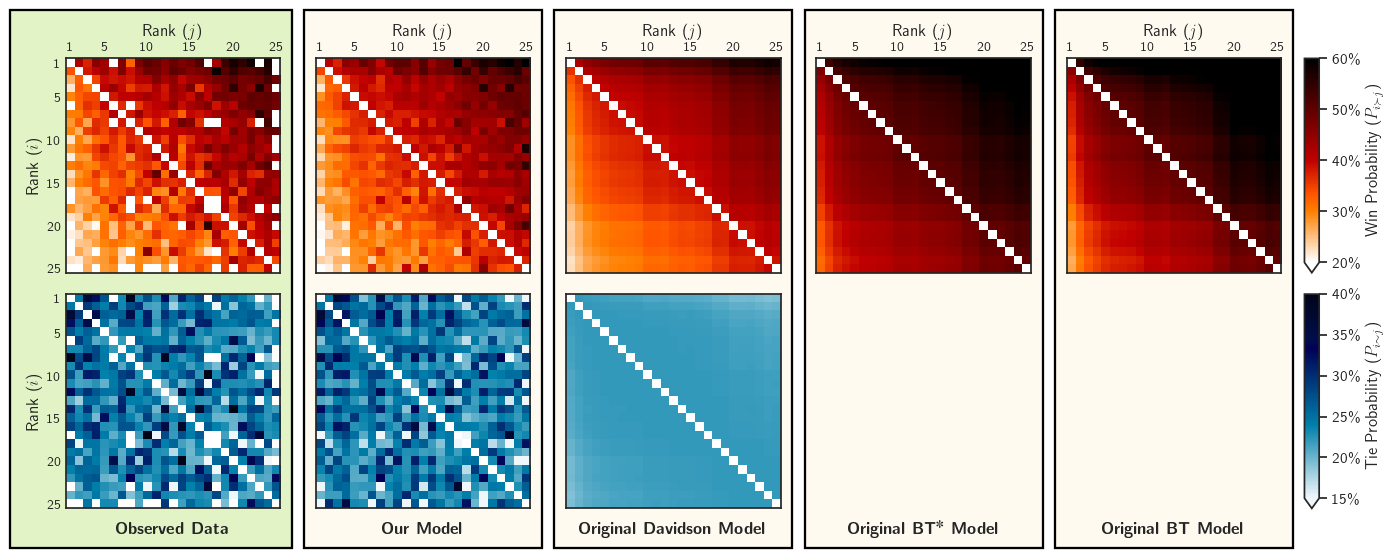

In [27]:
latex = True
save = True
density = True

benchmark_model = models[29]
score = benchmark_model.param[:benchmark_model.n_agents]
rank = np.argsort(score)[::-1]

max_rank = 27
rank = rank[:max_rank]

#model_orders = np.array([30, 18, 26, 14, 22, 10, 6, 3, 19, 7, 4, 1]) - 1
#model_orders = np.array([1, 7, 19, 18, 30]) - 1
model_orders = np.array([4, 1, 7, 18]) - 1

model_orders = model_orders[::-1]

rm_indices = np.array([10, 25]) - 1

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}

with texplot.theme(use_latex=True, font_scale=1):
    plt.rcParams.update(rc)
    
    # fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
    # Create a figure and GridSpec with 2 rows and 5 columns
    #fig = plt.figure(figsize=(15, 6))
    fig = plt.figure(figsize=(14.7, 6))
    gs = GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 1, 1],
                  wspace=0.006, hspace=0.1)
    
    ax = np.empty((2, 5), dtype=object)
    im = np.empty((2, 5), dtype=object)
    for i in range(2):
        for j in range(5):
            ax[i, j] = fig.add_subplot(gs[i, j])
            # ax[i, j].set_visible(False)

    from matplotlib.colors import LinearSegmentedColormap

    cmap_win = 'gist_heat_r'

    # Colormap for tie (altering ocean_r to remove green part, replace wth black)
    ocean_r = plt.get_cmap('ocean_r')
    colors = ocean_r(np.linspace(0, 1, 512))
    n_replace = int(0.7 * 512)
    green_to_black = np.linspace(colors[n_replace, :3], [0, 0, 0], 512 - n_replace)
    colors[n_replace:, :3] = green_to_black
    start = int(0.02 * 512)
    end = int(0.9 * 512)
    colors = colors[start:end, :3]
    cmap_tie = LinearSegmentedColormap.from_list('ocean_r_with_black_at_end', colors)

    min_win, max_win = 0.2, 0.6
    min_tie, max_tie = 0.15, 0.4

    im[0, 0] = plot_match_matrix(ax[0, 0], models[model_orders[0]], rank, density=True,
                                 source='observed', kind='win', data_range=[min_win, max_win],
                                 title='Win', xlabel=True, ylabel=True,
                                 cmap=cmap_win, rm_indices=rm_indices, save=save, latex=latex)
    
    im[1, 0] = plot_match_matrix(ax[1, 0], models[model_orders[0]], rank, density=True,
                                 source='observed', kind='tie', data_range=[min_tie, max_tie],
                                 title='Tie', xlabel=False, ylabel=True,
                                 cmap=cmap_tie, rm_indices=rm_indices, save=save, latex=latex)
    
    for i in range(model_orders.size):
    
        im[0, i+1] = plot_match_matrix(ax[0, i + 1], models[model_orders[i]], rank,
                                       density=True,source='predicted', kind='win',
                                       data_range=[min_win, max_win],
                                       title='Win',
                                       cmap=cmap_win, xlabel=True, ylabel=False,
                                       rm_indices=rm_indices, save=save, latex=latex)
    
        if not models[model_orders[i]].__class__.__name__.startswith('BradleyTerry'):
            im[1, i+1] = plot_match_matrix(ax[1, i + 1], models[model_orders[i]], rank,
                                           density=True, source='predicted', kind='tie',
                                           data_range=[min_tie, max_tie],
                                           title='Tie',
                                           cmap=cmap_tie, xlabel=False, ylabel=False,
                                           rm_indices=rm_indices, save=save, latex=latex)
        else:
            # A dummy plot with win data (this plot will not be shown)
            im[1, i+1] = plot_match_matrix(ax[1, i + 1], models[model_orders[i]], rank,
                                           density=True, source='predicted', kind='win',
                                           data_range=[min_tie, max_tie],
                                           title='Tie',
                                           cmap=cmap_tie, xlabel=False, ylabel=False,
                                           rm_indices=rm_indices, save=save, latex=latex)
            ax[1, i+1].axis('off')
    
    # Adjust layout to finalize subplot positions and save space
    plt.subplots_adjust(left=0.05, right=0.9, top=0.85, bottom=0.1)

    # ==================================================
    
    # Create one colorbar for each row, positioned to the far right
    for i in range(2):
    
        if i == 0:
            vmin, vmax = 100*min_win, 100*max_win
            clabel = r'Win Probability ($P_{i \succ j}$)'
            cmap = cmap_win
        else:
            vmin, vmax = 100*min_tie, 100*max_tie
            clabel = r'Tie Probability ($P_{i \sim j}$)'
            cmap = cmap_tie
            
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        pos_bottom = ax[i, 0].get_position()  # Bottom axis
        pos_top = ax[i, -1].get_position()
        cax = fig.add_axes([pos_top.x1 + 0.016, pos_bottom.y0, 0.01, pos_top.y1 - pos_bottom.y0])

        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, extend='min')
        cbar.set_label(clabel)
        cbar.ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
    
    ax[1, -1].set_visible(False)
    ax[1, -2].set_visible(False)
    
    # ================================================
    
    titles = [r'\textbf{Observed Data}',
              r'\textbf{Our Model}',
              r'\textbf{Original Davidson Model}',
              r'\textbf{Original BT\textsuperscript{\ding{93}} Model}',
              r'\textbf{Original BT Model}']
    
    # Second loop: Draw rectangles around the columns
    for i in range(5):
    
        ax[0, i].annotate(titles[i], xy=(0.5, -1.22), xycoords='axes fraction', ha='center',
                          fontsize=12, weight='bold')
    
        # Get the positions of the win and tie subplots
        pos_win = ax[0, i].get_position()  # Get position of the win subplot
        pos_tie = ax[1, i].get_position()  # Get position of the tie subplot
    
        bottom = 0.05
        top = 0.065
        margin = 0.008
    
        # Calculate the bounding box for the two subplots
        x0 = pos_win.x0 - margin  # x position of the left edge
        y0 = pos_tie.y0 - 2*margin - bottom  # y position of the bottom edge
        y1 = pos_win.y1  # y position of the top edge of the win matrix
        width = pos_win.width + 2.0 * margin  # width of the column
        height = y1 - y0 + 2.0 * margin + top  # total height
    
        dx = 0.03
        if i == 0:
            x0 = x0 - dx
            width = width + dx
            # bg_color = 'oldlace'
            # bg_color = (0.85, 0.94, 0.85)
            # bg_color = (0.83, 0.93, 0.83)
            bg_color = '#E2F4C6'
            # bg_color = '#E6F8B2'
        else:
            # bg_color = 'azure'
            # bg_color = 'linen'
            # bg_color = 'oldlace'
            # bg_color = 'whitesmoke'
            bg_color = 'floralwhite'
    
        # Create a rectangle that surrounds both subplots
        rect = patches.Rectangle((x0, y0),  # lower-left corner
                                 width,     # width of the rectangle
                                 height,    # total height (sum of both subplots)
                                 linewidth=1.65,
                                 edgecolor='black',
                                 facecolor=bg_color,
                                 transform=fig.transFigure,
                                 clip_on=False,
                                 zorder=-20)
        fig.patches.append(rect)
    
    # =========================================================
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.33, wspace=0.33)
    texplot.show_or_save_plot(plt, default_filename='match_matrix',
                              transparent_background=False,
                              dpi=200, show_and_save=save,
                              verbose=True)